In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
def plot_image(image):
  plt.imshow(image, cmap  ='binary')
  plt.axis('off')

In [6]:
# PCA va bo tu ma hoa tuyen tinh
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2 = 0.3, noise = 0.1):
  angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
  data = np.empty((m, 3))
  data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.rand(m) / 2
  data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.rand(m)/ 2
  data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.rand(m)
  return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis = 0, keepdims = 0)

In [7]:
# xay dung bo tu ma hoa
np.random.rand(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape = [2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = 'mse', optimizer =keras.optimizers.SGD(learning_rate = 1.5))
history = autoencoder.fit(X_train, X_train, epochs = 20)

Epoch 1/20
2/2 [==============================] - 5s 14ms/step - loss: 0.5121
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0680
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 11/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0298
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0

In [8]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 5ms/step


Saving figure linear_autoencoder_pca_plot


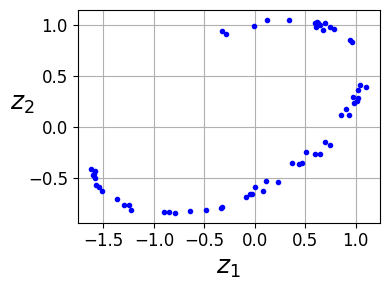

In [9]:
fig = plt.figure(figsize = (4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize = 18)
plt.ylabel('$z_2$', fontsize = 18, rotation = 0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()


In [10]:
# cac bo tu ma hoa xep chong
# su dung bo du lieu MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [11]:
# huan luyen tat ca cac tang 1 lan
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation ='selu'),
])
stacked_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss = 'binary_crossentropy',
                   optimizer = keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))


Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3384 - rounded_accuracy: 0.8869 - val_loss: 0.3129 - val_rounded_accuracy: 0.9127
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3042 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2984 - rounded_accuracy: 0.9218 - val_loss: 0.3026 - val_rounded_accuracy: 0.9132
Epoch 4/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2943 - rounded_accuracy: 0.9255 - val_loss: 0.2938 - val_rounded_accuracy: 0.9279
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2918 - rounded_accuracy: 0.9275 - val_loss: 0.2915 - val_rounded_accuracy: 0.9291
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2899 - rounded_accuracy: 0.9290 - val_loss: 0.2903 - val_rounded_accuracy: 0.9304
Epoch 7/20
1719/1719 [================

1/1 [==============================] - 0s 115ms/step
Saving figure reconstruction_plot


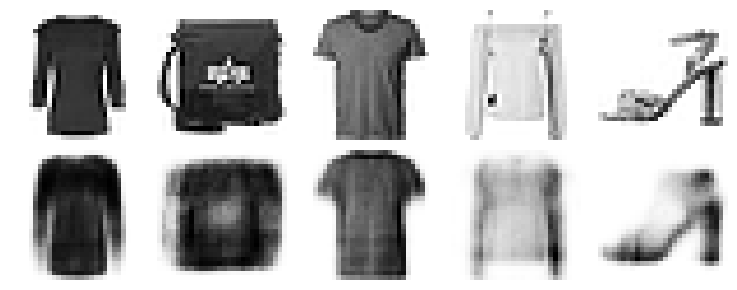

In [13]:
def show_reconstructions(model, images = X_valid, n_images = 5):
  reconstructions =model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

In [14]:
# minh hoa bo MNIST Fashion
np.random.seed(42)

from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 3ms/step


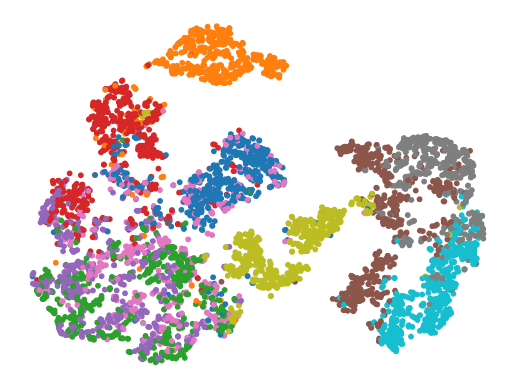

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = y_valid, s =10, cmap = 'tab10')
plt.axis('off')
plt.show()

Saving figure fashion_mnist_visualization_plot


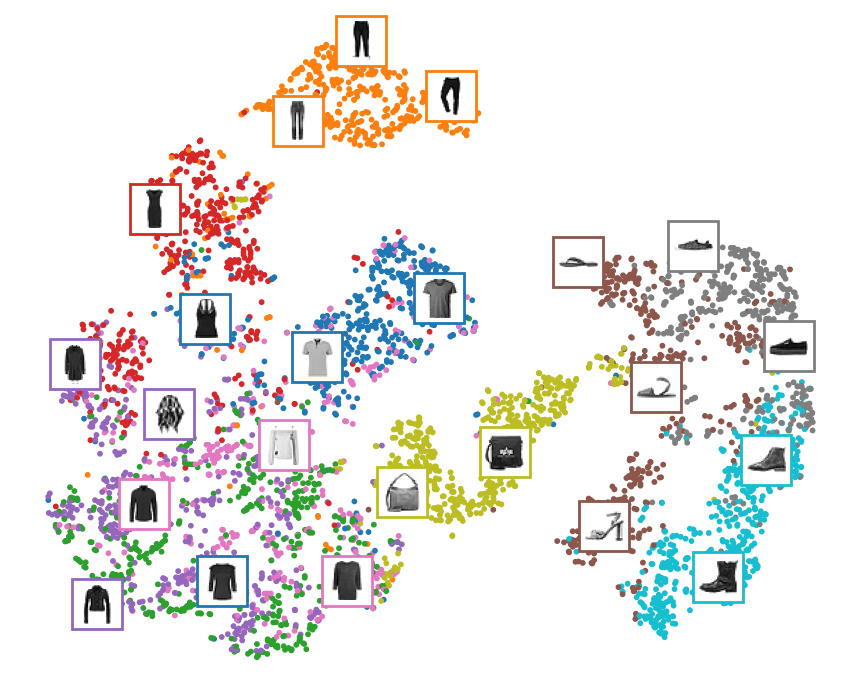

In [16]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [17]:
# trong so rang buoc
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation = 'selu')
dense_2 = keras.layers.Dense(30, activation = 'selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation = 'selu'),
    DenseTranspose(dense_1, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss = 'binary_crossentropy',
                optimizer = keras.optimizers.SGD(learning_rate=1.5), metrics = [rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs = 10, validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.3260 - rounded_accuracy: 0.8970 - val_loss: 0.3072 - val_rounded_accuracy: 0.9080
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2968 - rounded_accuracy: 0.9231 - val_loss: 0.2952 - val_rounded_accuracy: 0.9267
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2911 - rounded_accuracy: 0.9283 - val_loss: 0.3024 - val_rounded_accuracy: 0.9069
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2882 - rounded_accuracy: 0.9309 - val_loss: 0.2882 - val_rounded_accuracy: 0.9338
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2864 - rounded_accuracy: 0.9326 - val_loss: 0.2866 - val_rounded_accuracy: 0.9341
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2851 - rounded_accuracy: 0.9338 - val_loss: 0.2861 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [============

1/1 [==============================] - 0s 145ms/step


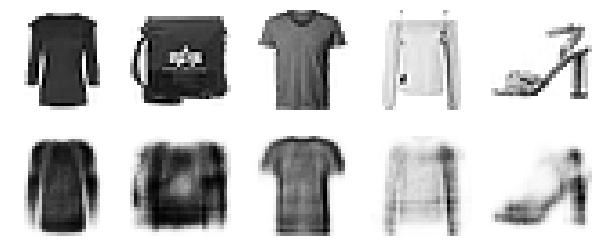

In [19]:
show_reconstructions(tied_ae)
plt.show()

In [20]:
# huan luyen bo ma hoa tai 1 thoi diem
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
  n_inputs = X_train.shape[-1]
  encoder = keras.models.Sequential([
      keras.layers.Dense(n_neurons, activation = 'selu', input_shape = [n_inputs])
  ])
  decoder = keras.models.Sequential([
      keras.layers.Dense(n_inputs, activation = output_activation),
  ])
  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(optimizer, loss, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs = n_epochs,
                  validation_data = (X_valid, X_valid))
  return encoder, decoder, encoder(X_train), encoder(X_train)

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, 'binary_crossentropy',
    keras.optimizers.SGD(learning_rate = 1.5), output_activation = 'sigmoid',
    metrics = [rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.SGD(learning_rate = 0.05),
    output_activation = 'selu')

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3437 - rounded_accuracy: 0.8883 - val_loss: 0.3113 - val_rounded_accuracy: 0.9160
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3029 - rounded_accuracy: 0.9215 - val_loss: 0.2995 - val_rounded_accuracy: 0.9258
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2940 - rounded_accuracy: 0.9297 - val_loss: 0.2926 - val_rounded_accuracy: 0.9325
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2885 - rounded_accuracy: 0.9349 - val_loss: 0.2882 - val_rounded_accuracy: 0.9370
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9384 - val_loss: 0.2852 - val_rounded_accuracy: 0.9400
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2822 - rounded_accuracy: 0.9410 - val_loss: 0.2829 - val_rounded_accuracy: 0.9415
Epoch 7/10
1719/1719 [==============

In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 201ms/step


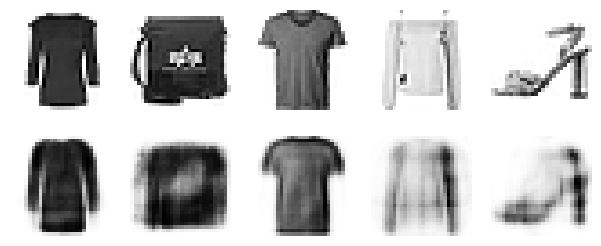

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
# su dung tang tich chap thay tang ma hoa day dac
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 10ms/step - loss: 0.3003 - rounded_accuracy: 0.9207 - val_loss: 0.2813 - val_rounded_accuracy: 0.9348
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2748 - rounded_accuracy: 0.9424 - val_loss: 0.2725 - val_rounded_accuracy: 0.9458
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2703 - rounded_accuracy: 0.9471 - val_loss: 0.2694 - val_rounded_accuracy: 0.9505
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2679 - rounded_accuracy: 0.9497 - val_loss: 0.2679 - val_rounded_accuracy: 0.9503
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2662 - rounded_accuracy: 0.9516 - val_loss: 0.2661 - val_rounded_accuracy: 0.9531


In [25]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

In [26]:
# bo ma hoa hoi tiep (su dung doi voi van ban, chuoi thoi gian)
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = [28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation ='sigmoid'))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(0.1),
                     metrics = [rounded_accuracy])

In [27]:
history = recurrent_ae.fit(X_train, X_train, epochs = 10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 25s 11ms/step - loss: 0.4978 - rounded_accuracy: 0.7710 - val_loss: 0.4283 - val_rounded_accuracy: 0.8233
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3924 - rounded_accuracy: 0.8513 - val_loss: 0.3743 - val_rounded_accuracy: 0.8603
Epoch 3/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3632 - rounded_accuracy: 0.8713 - val_loss: 0.3640 - val_rounded_accuracy: 0.8721
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3523 - rounded_accuracy: 0.8789 - val_loss: 0.3473 - val_rounded_accuracy: 0.8838
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3446 - rounded_accuracy: 0.8843 - val_loss: 0.3418 - val_rounded_accuracy: 0.8871
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3378 - rounded_accuracy: 0.8890 - val_loss: 0.3360 - val_rounded_accuracy: 0.8887
Epoch 7/10
1719/1719 [======

1/1 [==============================] - 1s 1s/step


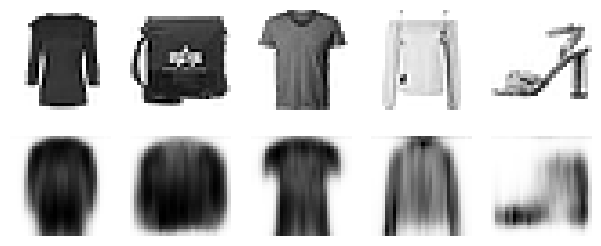

In [28]:
show_reconstructions(recurrent_ae)
plt.show()

In [29]:
# bo ma hoa khu nhieu xep chong
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 1.0),
                    metrics = [rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs = 10,
                           validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3511 - rounded_accuracy: 0.8764 - val_loss: 0.3211 - val_rounded_accuracy: 0.9063
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3137 - rounded_accuracy: 0.9083 - val_loss: 0.3084 - val_rounded_accuracy: 0.9155
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3063 - rounded_accuracy: 0.9147 - val_loss: 0.3034 - val_rounded_accuracy: 0.9184
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3023 - rounded_accuracy: 0.9183 - val_loss: 0.2997 - val_rounded_accuracy: 0.9231
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2991 - rounded_accuracy: 0.9210 - val_loss: 0.2971 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2971 - rounded_accuracy: 0.9227 - val_loss: 0.2954 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 78ms/step


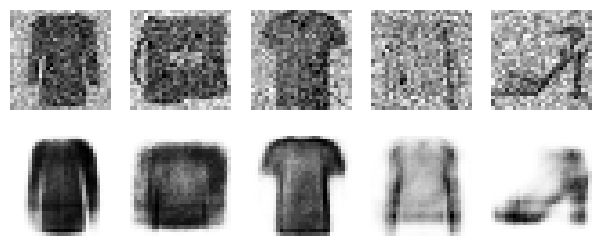

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training = True))
plt.show()

In [31]:
# su dung dropout
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(0.5),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 1.0),
                   metrics = [rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs = 10,
                         validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4974 - rounded_accuracy: 0.7270 - val_loss: 0.4928 - val_rounded_accuracy: 0.7303
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4903 - rounded_accuracy: 0.7311 - val_loss: 0.4928 - val_rounded_accuracy: 0.7298
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4903 - rounded_accuracy: 0.7310 - val_loss: 0.4930 - val_rounded_accuracy: 0.7278
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4902 - rounded_accuracy: 0.7311 - val_loss: 0.4934 - val_rounded_accuracy: 0.7263
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4903 - rounded_accuracy: 0.7311 - val_loss: 0.4928 - val_rounded_accuracy: 0.7265
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4902 - rounded_accuracy: 0.7310 - val_loss: 0.4930 - val_rounded_accuracy: 0.7260
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 76ms/step
Saving figure dropout_denoising_plot


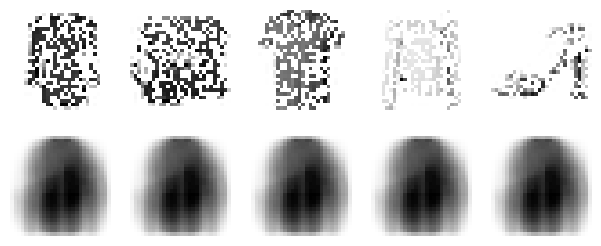

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training = True))
save_fig('dropout_denoising_plot', tight_layout = False)

In [33]:
# bo ma hoa thua
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28 , 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'sigmoid'),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss = 'binary_crossentropy', optimizer  = keras.optimizers.SGD(learning_rate = 1.),
                  metrics = [rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4300 - rounded_accuracy: 0.7987 - val_loss: 0.3749 - val_rounded_accuracy: 0.8521
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3576 - rounded_accuracy: 0.8715 - val_loss: 0.3479 - val_rounded_accuracy: 0.8828
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3386 - rounded_accuracy: 0.8876 - val_loss: 0.3338 - val_rounded_accuracy: 0.8918
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3257 - rounded_accuracy: 0.8985 - val_loss: 0.3240 - val_rounded_accuracy: 0.9018
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3201 - rounded_accuracy: 0.9021 - val_loss: 0.3206 - val_rounded_accuracy: 0.9041
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3174 - rounded_accuracy: 0.9039 - val_loss: 0.3179 - val_rounded_accuracy: 0.9040
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 63ms/step


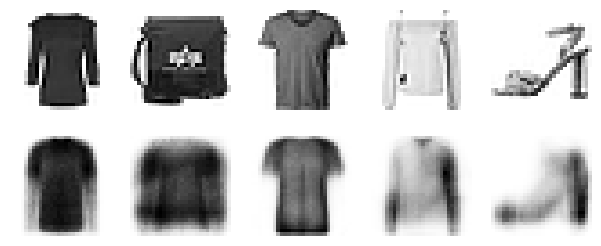

In [34]:
show_reconstructions(simple_ae)
plt.show()

In [35]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins = bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width = widths * 0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
      lambda y, position: '{}%'.format(int(np.round(100 * y)))))
  ax.grid(True)

In [36]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Trung bình Toàn cục = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Kích hoạt")
    ax1.set_ylabel("% Kích hoạt")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Nơ-ron Kích hoạt Trung bình")
    ax2.set_ylabel("% Nơ-ron")
    ax2.axis([0, 1, 0, height])

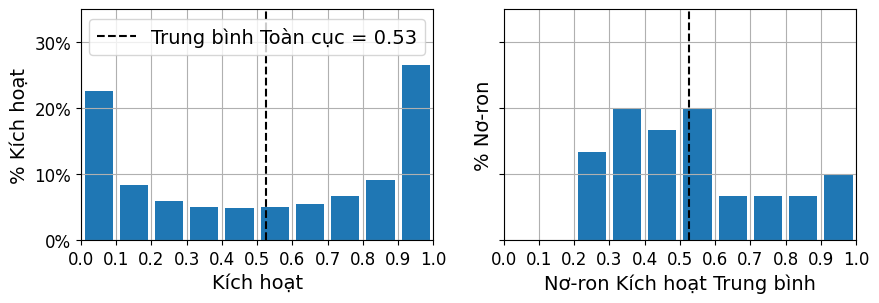

In [37]:
plot_activations_histogram(simple_encoder, height = 0.35)
plt.show()

In [38]:
# them chuan l1 vao tang ma hoa
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4328 - rounded_accuracy: 0.8114 - val_loss: 0.3824 - val_rounded_accuracy: 0.8535
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3702 - rounded_accuracy: 0.8675 - val_loss: 0.3651 - val_rounded_accuracy: 0.8731
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3555 - rounded_accuracy: 0.8789 - val_loss: 0.3509 - val_rounded_accuracy: 0.8805
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3423 - val_rounded_accuracy: 0.8908
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3376 - rounded_accuracy: 0.8919 - val_loss: 0.3371 - val_rounded_accuracy: 0.8929
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3333 - rounded_accuracy: 0.8952 - val_loss: 0.3327 - val_rounded_accuracy: 0.8963
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 81ms/step


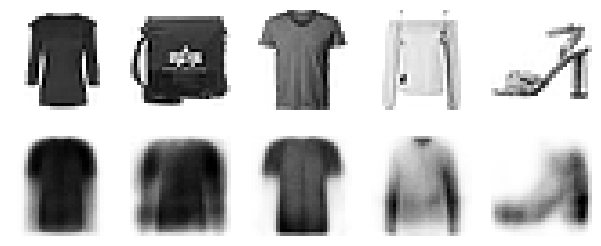

In [39]:
show_reconstructions(sparse_l1_ae)

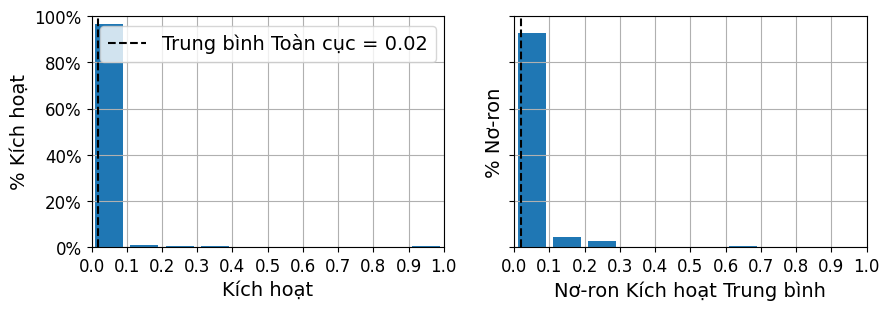

In [40]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Saving figure sparsity_loss_plot


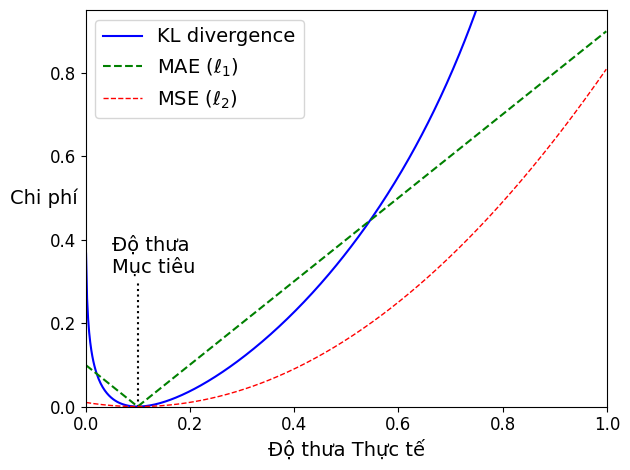

In [41]:
# su dung phan li KL danh gia do thua va do nhot
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Độ thưa\nMục tiêu", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Độ thưa Thực tế")
plt.ylabel("Chi phí", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [42]:
from keras.src.losses import kl_divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis = 0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities))

In [43]:
tf.random.set_seed(42)
np.random .seed(42)

kld_reg = KLDivergenceRegularizer(weight = 0.05, target = 0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(300, activation = 'sigmoid', activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [300]),
    keras.layers.Dense(28 * 28, activation ='sigmoid'),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 1.0),
                             metrics = [rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs = 10,
                           validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4118 - rounded_accuracy: 0.8173 - val_loss: 0.3700 - val_rounded_accuracy: 0.8602
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3505 - rounded_accuracy: 0.8793 - val_loss: 0.3411 - val_rounded_accuracy: 0.8884
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3312 - rounded_accuracy: 0.8948 - val_loss: 0.3268 - val_rounded_accuracy: 0.9002
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3212 - rounded_accuracy: 0.9031 - val_loss: 0.3208 - val_rounded_accuracy: 0.9047
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3166 - rounded_accuracy: 0.9067 - val_loss: 0.3168 - val_rounded_accuracy: 0.9082
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3132 - rounded_accuracy: 0.9097 - val_loss: 0.3136 - val_rounded_accuracy: 0.9107
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 102ms/step


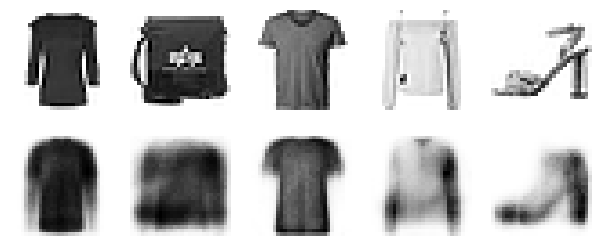

In [44]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


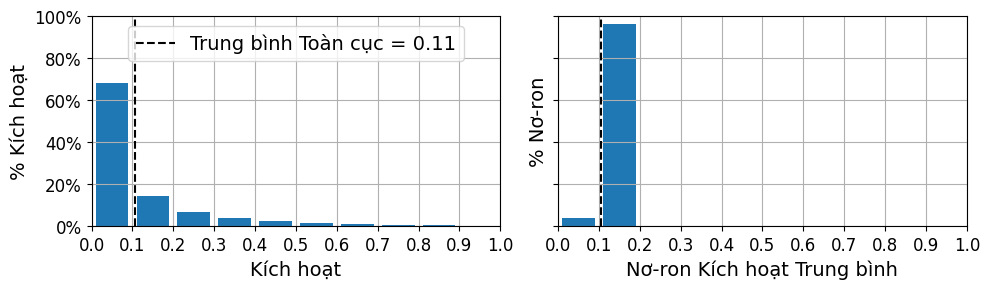

In [45]:
plot_activations_histogram(sparse_kl_encoder)
save_fig('sparse_autoencoder_plot')
plt.show()

In [46]:
# bo tu ma hoa bien phan
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10
inputs = keras.layers.Input(shape = [28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation = 'selu')(z)
z = keras.layers.Dense(150, activation = 'selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape = [codings_size])
x = keras.layers.Dense(100, activation = 'selu')(decoder_inputs)
x = keras.layers.Dense(150, activation = 'selu')(x)
x = keras.layers.Dense(28 * 28, activation =  'sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs = [decoder_inputs], outputs = [outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 7ms/step - loss: 0.4161 - rounded_accuracy: 0.8337 - val_loss: 0.3693 - val_rounded_accuracy: 0.8825
Epoch 2/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3555 - rounded_accuracy: 0.8887 - val_loss: 0.3483 - val_rounded_accuracy: 0.8955
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3441 - rounded_accuracy: 0.8968 - val_loss: 0.3423 - val_rounded_accuracy: 0.9011
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3379 - rounded_accuracy: 0.9016 - val_loss: 0.3390 - val_rounded_accuracy: 0.9021
Epoch 5/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3337 - rounded_accuracy: 0.9049 - val_loss: 0.3367 - val_rounded_accuracy: 0.9059
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3304 - rounded_accuracy: 0.9074 - val_loss: 0.3311 - val_rounded_accuracy: 0.9095
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 121ms/step


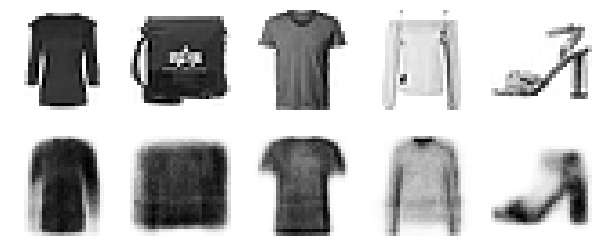

In [48]:
show_reconstructions(variational_ae)
plt.show()

In [49]:
# sinh cac hinh anh thoi trang
def plot_multiple_images(images, n_cols = None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis = 1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')

Saving figure vae_generated_images_plot


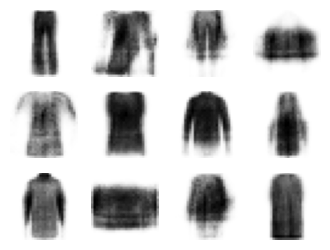

In [50]:
# sinh cac hinh anh thoi trang
tf.random.set_seed(42)

codings = tf.random.normal(shape = [12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig('vae_generated_images_plot', tight_layout=False)

Saving figure semantic_interpolation_plot


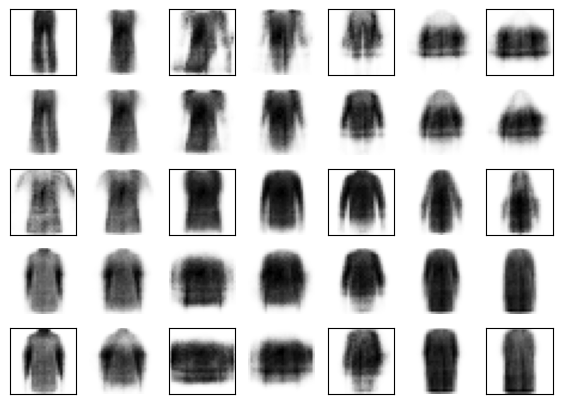

In [51]:
# thuc hien phep noi suy theo nhom
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

In [52]:
# mang doi sinh
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30
# bo sinh
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
# bo phan biet that va
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [53]:
discriminator.compile(loss = 'binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

In [54]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [55]:
def train_gan(gan, datset, batch_size, codings_size, n_epochs = 50):
  generator.discriminator = gan.layers
  for epoch in range(n_epochs):
    print('Epoch{}/{}'.format(epoch+1, n_epochs))
    # chay chuong trinh voi bo phat hien that gia
    for X_batch in dataset:
      noise = tf.random.normal(shape = [batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # chay mo hinh voi mo hinh sinh
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8)
    plt.show()

Epoch1/1


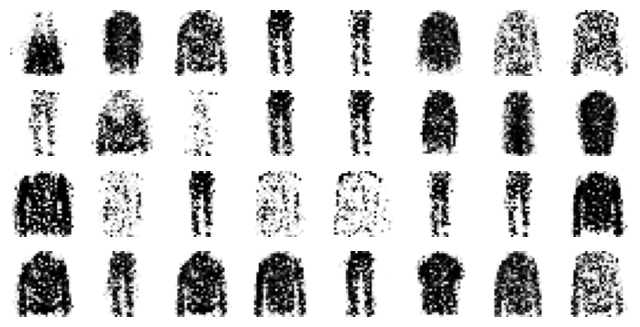

In [56]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs = 1)

Saving figure gan_generated_images_plot


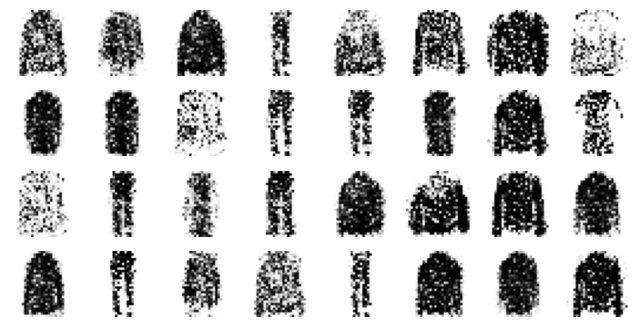

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape = [batch_size, codings_size])
generated_images  =generator(noise)
plot_multiple_images(generated_images, 8)
save_fig('gan_generated_images_plot', tight_layout = False)

Saving figure gan_generated_images_plot


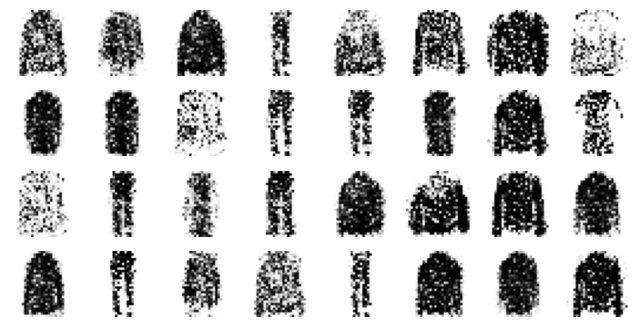

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape = [batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig('gan_generated_images_plot', tight_layout = False)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

Output hidden; open in https://colab.research.google.com to view.

In [1]:
# GAN tich chap sau
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.Conv2DTranspose(64, kernel_size = 5, strides=2, padding = 'SAME',
                          activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding = 'SAME',
                                 activation = 'tanh'),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = 'SAME',
                        activation = keras.layers.LeakyReLU(0.2),
                        input_shape = [28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'SAME',
                        activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])
gan = keras.models.Sequential([generator, discriminator])

NameError: ignored

In [2]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

NameError: ignored

In [3]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. -1.

NameError: ignored

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.bacth(batch_size, drop_remainder = True).prefetch(1)

NameError: ignored

In [5]:
train_gan(gan, dataset, batch_size, codings_size)

NameError: ignored